# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import tqdm
import random

from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

### Подготовка данных

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_random_seed(1997)
from torchvision import transforms
import PIL

train_transform = transforms.Compose([
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.ImageFolder("../input/iad-img-classification/dataset/dataset/train", transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder("../input/iad-img-classification/dataset/dataset/val", transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET
# OR USE torchvision.datasets.ImageFolder INSTEAD OF MyDataset

In [4]:
train_rand = np.random.choice(len(train_dataset), 1000, replace=False)
val_rand = np.random.choice(len(val_dataset), 100, replace=False)

train_subset = torch.utils.data.Subset(train_dataset, train_rand)
val_subset = torch.utils.data.Subset(val_dataset, val_rand)

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=2)

In [6]:
next(iter(train_dataloader))[0].size()

torch.Size([128, 3, 64, 64])

### Смотрим на данные

In [7]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  #unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

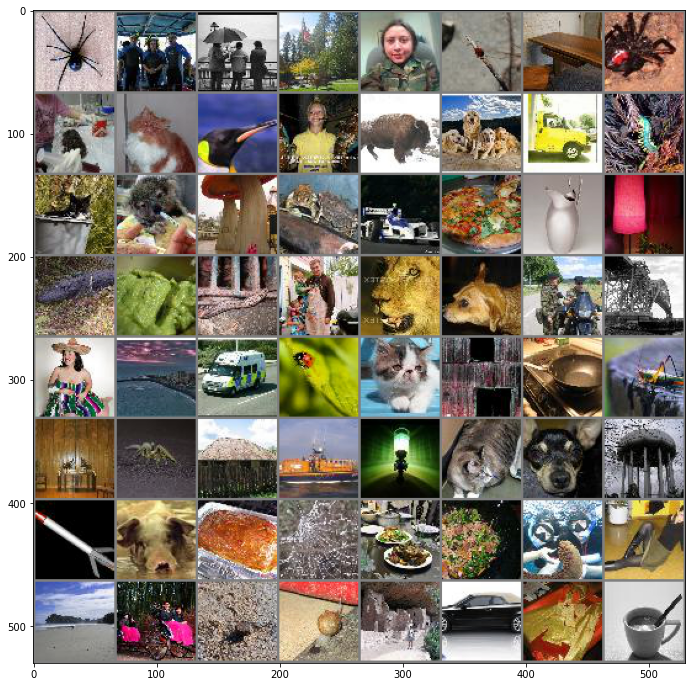

In [8]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12,12))
# create grid of images
img_grid = torchvision.utils.make_grid(images[:64])
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [9]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [10]:
def plot_history(train_history, val_history, title="Loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="Train", c="darkcyan", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="red", label="Val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()
    
    plt.show()

In [11]:
set_random_seed(1997)
def train_one_epoch(model, train_dataloader, criterion, optimizer, epoch, device):
    train_losses = []
    train_hits = 0
    train_size = 0
    
    model.train()
    for imgs, labels in tqdm(train_dataloader, desc=f"Training. Epoch {epoch + 1}", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        y_pred = model(imgs)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())

        pred_classes = torch.argmax(y_pred, dim=-1)
        train_hits += (pred_classes == labels).sum().item()
        train_size += y_pred.size(0)
    return train_losses, train_hits / train_size  # Loss_list, Accuracy

def predict(model, val_dataloder, criterion, device):
    val_losses = []
    true_classes = torch.Tensor([]).to(device)
    predicted_classes = torch.Tensor([]).to(device)
    
    model.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader, desc="Validating.", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            val_losses.append(loss.item())
            
            batch_pred_classes = torch.argmax(y_pred, dim=-1)
            predicted_classes = torch.cat((predicted_classes, batch_pred_classes), dim=0)
            true_classes = torch.cat((true_classes, labels), dim=0)
            
    return val_losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs=10, scheduler=None):
    model.to(device)
    epochs_train_loss, epochs_train_accuracy = [], []  # List of Loss, Accuracy per epoch on train
    epochs_val_loss, epochs_val_accuracy = [], []      # List of Loss, Accuracy per epoch on val
    
    for epoch in range(n_epochs):
        # Train Accuracy and Losses
        train_losses, train_accuracy = train_one_epoch(model, train_dataloader, criterion, optimizer, epoch, device)
        epochs_train_loss.append(np.mean(train_losses))
        epochs_train_accuracy.append(train_accuracy)

        # Val Accuracy and Losses
        val_losses, val_pred, val_true = predict(model, val_dataloader, criterion, device)
        epochs_val_loss.append(np.mean(val_losses))
        epochs_val_accuracy.append((val_pred == val_true).sum().item() / val_true.size(0))

        # Printing epoch results
        clear_output()
        print(pd.DataFrame({'Train Loss': epochs_train_loss, 
                            'Val Loss': epochs_val_loss, 
                            'Train Acc:': epochs_train_accuracy, 
                            'Val Acc:': epochs_val_accuracy}))
        plot_history(train_losses, epochs_val_loss)

### Обучение модели, запуски экспериментов

In [14]:
model_based = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.SELU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.SELU(),
    nn.MaxPool2d(2, 2),  # 32x32
    # nn.Dropout(0.2),
    
    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.SELU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.SELU(),
    nn.MaxPool2d(2, 2),  # 16x16
    nn.Dropout(0.2),
    
    nn.Conv2d(64, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.SELU(),
    nn.Conv2d(128, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.SELU(),
    nn.MaxPool2d(2, 2),  # 8x8
    # nn.Dropout(0.2),

    nn.Conv2d(128, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.SELU(),
    nn.Conv2d(128, 256, 3, padding=1),
    nn.BatchNorm2d(256),
    nn.SELU(),
    nn.MaxPool2d(2, 2),  # 4x4
    nn.Dropout(0.2),
    
    nn.Flatten(),
    nn.Linear(256 * 4 * 4, 1024),
    nn.BatchNorm1d(1024),
    nn.SELU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 200),
)

optimizer = torch.optim.Adam(model_based.parameters(), lr=1e-3)  # YOUR OPTIMIZER
criterion = nn.CrossEntropyLoss()                                # LOSS THAT YOU OPTIMIZE
scheduler = None                                                 # LR SCHEDULE THAT YOU PROBABLY CHOOSE
n_epochs = 20
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    Train Loss  Val Loss  Train Acc:  Val Acc:
0     4.426648  3.852071     0.09834    0.1666
1     3.740445  3.379630     0.18397    0.2372
2     3.447209  3.217853     0.23105    0.2614
3     3.242448  3.048940     0.26601    0.2943
4     3.083710  2.934804     0.29467    0.3150
5     2.941832  2.794508     0.32220    0.3436
6     2.831927  2.711255     0.34182    0.3642
7     2.720551  2.669970     0.36350    0.3716
8     2.626052  2.608282     0.38145    0.3803
9     2.544085  2.550639     0.39679    0.3927
10    2.472069  2.499633     0.41055    0.4064
11    2.400003  2.485818     0.42409    0.4094
12    2.329506  2.449901     0.43784    0.4162
13    2.269027  2.410070     0.45234    0.4319
14    2.212509  2.362340     0.46265    0.4343
15    2.156035  2.397440     0.47337    0.4330
16    2.103292  2.365349     0.48452    0.4348
17    2.050009  2.345862     0.49521    0.4443
18    2.004776  2.337395     0.50351    0.4457
19    1.958307  2.300479     0.51395    0.4526


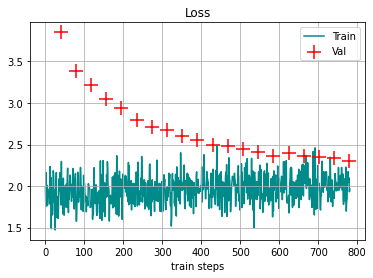

In [16]:
set_random_seed(1997)
train(model_based, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

In [28]:
all_losses, predicted_labels, true_labels = predict(model_based, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy_score(predicted_labels.cpu(), true_labels.cpu())
print("tests passed")

tests passed


### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [27]:
all_losses, predicted_labels, true_labels = predict(model_based, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels.cpu(), predicted_labels.cpu())
print("Оценка за это задание составит {} баллов".format(min(10, 10 * accuracy / 0.44)))

Оценка за это задание составит 10 баллов


### Отчёт об экспериментах 

Первые запуски проводил на подвыборке из 10к/1к (train/val) изображений. 

Базовая модель состояла из двух VGG-блоков и двух линейных слоёв, каждый VGG-блок содержал 2 свертки 32х32, BatchNorm, Dropout(0.2) и MaxPool каждые две свёртки. 
```
nn.Conv2d(3, 32, 3, padding=1),
nn.BatchNorm2d(32),
nn.SELU(),
nn.Conv2d(32, 32, 3, padding=1),
nn.BatchNorm2d(32),
nn.SELU(),
nn.MaxPool2d(2, 2),  # 32x32
nn.Dropout(0.2),

nn.Conv2d(32, 64, 3, padding=1),
nn.BatchNorm2d(64),
nn.SELU(),
nn.Conv2d(64, 64, 3, padding=1),
nn.BatchNorm2d(64),
nn.SELU(),
nn.MaxPool2d(2, 2),  # 16x16
nn.Dropout(0.2),

nn.Flatten(),
nn.Linear(32 * 16 * 16, 1024),
nn.BatchNorm1d(1024),
nn.SELU(),
nn.Dropout(0.5),
nn.Linear(1024, 200),
```
Val_Acc = 5.9%. 
Потестив более жирные свертки 64х64 и 128х128 качество только ухудшилось, а время обучения возросло) \\
Добавление следующих аугментаций дало Val_Acc = 6.5%:
```
transforms.ColorJitter(hue=.05, saturation=.05),
transforms.RandomHorizontalFlip(),
transforms.RandomRotation(20, resample=PIL.Image.NEAREST),
```
Позже убрав случайные повороты качество улучшилось, поэтому совет на будущее: не стоит сразу фигачить много аугментаций.

Смело запустив GPU, я обучил модель на всём датасете и вышло 11% accuracy, что мне показалось плохим результатом. 
Позже оказалось, что основной прирост в качестве дают следующие эпохи, поэтому надо смотреть на динамику хотя бы в теение 2 эпох.
Размер батча был 128, снизив до 32, качество стало ужасное, так как надо было корректировать learning rate, что я не хотел делать. 
В итоге обратно поставил 128)

Хорошие результаты пошли, когда я добавил еще сверток, а не расширял размер текущих. 
Причем до этого на выходе из сверточынх слоев у меня была картинка 16x16, что при вытягивании давало десятки тысячи нейронов. 
Поэтому гораздо лучше делать больше сверток, чтоб после всех Макспулингов картинка была буквально 4x4. 
И при умножении на число каналов выходило около 2-4 тысяч нейронов. 
Это наверное самый главный совет для работы с картинками: БОЛЬШЕ СВЁРТОК!

Добавление еще одного VGG-блока дало 13.1% accuracy на одной эпохе. 
До этого момента больше одной эпохи не смотрел, а зря, уже на второй эпохе качество резко поднялось.
Стало понятно, что пора брать больше эпох, так как база уже была приемлемой.
Добавив еще один блок на двух эпохах получился сильный скачок в accuracy с 15.8% до 22.93%.

Что касается линейных слоев, то вполне хватает одного, максимум два слоя с большим дропаутом (здесь 0.5).
Так как нейронов несколько тысяч и связей образуется слишком много, модель рискует переобучиться.

По советам коллег убрал пару дропаутов внутри сверток и пустил модель на 20 эпох. 
По динамике очень бодро падал лосс и росло аккураси, что уже к 17-18 эпохе был пробит порог 0.44.